<a href="https://colab.research.google.com/github/vik164/Deep-Learning/blob/main/VIKRANT_KUMAR_101195442_A3_CIFAR_10_CLASSIFER_DONES_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install the `torchmetrics` library for evaluation.

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics.classification import Accuracy
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_CLASSES = 10

In [ ]:
def load_data(T, batch_size):
  train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=T)
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=T)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

In [ ]:
def plot_results(train_losses, test_losses, test_accuracies):
  """
  Plot the train and test losses and accuracy values over a number of epochs.
  """
  fig, ax = plt.subplots(1, 2, figsize=(9, 3))

  ax[0].plot(train_losses, label='Train Loss')
  ax[0].plot(test_losses, label='Test Loss', color='red')
  ax[0].legend()
  ax[1].plot([value for value in test_accuracies], label='Test Accuracy', color='green')

  ax[0].set_title('Train / Test Loss')
  ax[1].set_title('Test Accuracy')

  plt.show()

# Q1. Complete the following implementations:
- `train_epoch`
- `eval_model`
- `run_experiment`
- `SimpleCNN`
- `ResNet50Transfer`
- `VGGTransfer`


In the following functions, you are training and evaluating the model for just one epoch (One full pass through the dataset). Complete the `train_epoch` and `eval_model` functions.

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
  """
  Train the model for one epoch.

  args:
    model: torch.nn.Module, the model to train
    train_loader: torch.utils.data.DataLoader, the dataloader for the training set
    optimizer: torch.optim.Optimizer, the optimizer to use
    criterion: torch.nn.Module, the loss function to use
    device: torch.device

  returns:
    train_loss: float, the average loss over the training set for this epoch
  """
  running_loss = 0.0
  # set the model to training e.g. enable dropouts
  model.train()
  # Iterate through the batch of samples in the train set
  for batch_idx, (data, target) in enumerate(train_loader):
    # zero the previously calculated gradients
    optimizer.zero_grad()

    # make predictions
    data, target = data.to(device), target.to(device)
    output = model(data)

    # calculate the loss
    loss = criterion(output, target)

    # calculate the gradient of the loss
    loss.backward()

    # adjust the model parameters based on the gradient
    optimizer.step()

    # keep track of the loss
    running_loss += loss.item()

  # return the average of the loss over all of the batches
  return running_loss / len(train_loader)

def eval_model(model, test_loader, criterion, acc, device):

  """
  Evaluate the model on the test set.

  args:
    model: torch.nn.Module, the model to evaluate
    test_loader: torch.utils.data.DataLoader, the dataloader for the test set
    criterion: torch.nn.Module, the loss function to use
    acc: torchmetrics.Accuracy, the accuracy metric object
    device: torch.device

  returns:
    test_loss: float, the average loss over the test set
    test_acc: float, the accuracy over the test set
  """

  running_loss = 0.0
  # set the model to eval mode e.g. disable dropouts
  model.eval()

  # reset the calculated accuracy object
  acc.reset()

  # make sure the following does not affect the gradient calculation
  with torch.no_grad():
    # Iterate through the batch of samples in the test set
    for data, target in test_loader:
      # make predictions
      data, target = data.to(device), target.to(device)
      outputs = model(data)
      # calculate the loss
      loss = criterion(outputs, target)
      # keep track of the loss
      running_loss += loss.item()
      # update the overall accuracy by including the accuracy of this batch
      acc.update(outputs, target)

  # return:
    # the average loss over the test set
    # the accuracy over the test set
  testLoss = running_loss / len(test_loader)
  testAcc = acc.compute().item()
  return testLoss, testAcc

In the following function you will use the previous function to train the model over a number of epochs. Complete the `run_experiment` function.

In [ ]:
def run_experiment(model, train_loader, test_loader, optimizer, criterion, device, epochs=10):
  """
  Run the experiment for a given number of epochs.

  args:
    model: torch.nn.Module, the model to train
    train_loader: torch.utils.data.DataLoader, the dataloader for the training set
    test_loader: torch.utils.data.DataLoader, the dataloader for the test set
    optimizer: torch.optim.Optimizer, the optimizer to use
    criterion: torch.nn.Module, the loss function to use
    device: torch.device
    epochs: int, the number of epochs to train for

  returns:
    train_losses: list of floats, the train loss for each epoch
    test_losses: list of floats, the test loss for each epoch
    accuracies: list of floats, the test accuracy for each epoch
  """
  train_losses = []
  test_losses = []
  accuracies = []

  acc = Accuracy('multiclass', num_classes=NUM_CLASSES).to(device) # Initialize the accuracy object

  # Interate through the number of epochs
  for e in range(epochs):
    # Train the model (using the `train_epoch` function)
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    # Keep track of the training loss for this epoch
    train_losses.append(train_loss)

    # Evaluate the model (using the `eval_model` function)
    test_loss, test_acc = eval_model(model, test_loader, criterion, acc, device)
    # Keep track of the testing loss and the testing accuracy for this epoch
    test_losses.append(test_loss)
    accuracies.append(test_acc)

  print("Finished training.")

  # return:
    # train_losses: list of floats, the train loss for each epoch
    # test_losses: list of floats, the test loss for each epoch
    # accuracies: list of floats, the test accuracy for each epoch
  return train_losses, test_losses, accuracies

In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    # Convolution(3x3 kernel) channels: 3 -> 32
    # ReLU
    # Max pooling (2x2)
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)

    # Convolution(3x3 kernel) channels: 32 -> 64
    # ReLU
    # Max pooling (2x2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)

    # Convolution(3x3 kernel) channels: 64 -> 128
    # ReLU
    # Max pooling (2x2)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)

    # Linear 512 hidden_dim
    # ReLU
    # Linear output -> num_classes
    self.fc1 = nn.Linear(512, 512)
    self.fc2 = nn.Linear(512, num_classes)



  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)
    x = x.view(-1, 512)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
class ResNet50Transfer(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    # Initialize Resnet 50 with the default weights
    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    # Freeze the resnet weights
    for i in model.parameters():
      i.requires_grad = False

    # replace the last fully connected layers with the following:
      # Linear 256 hidden_dim
      # ReLU
      # Linear output -> num_classes
    model.fc = nn.Sequential(
      nn.Linear(2048, 256),
      nn.ReLU(),
      nn.Linear(256, num_classes)
    )

    self.model = model

  def forward(self, x):
    return self.model(x)

# Q2. Run the following experiments and report the results.
- Train and evaluate the `SimpleCNN` model on the CIFAR-10 dataset (for 5 epochs minimum).
- Plot the train and test loss, as well as the test accuracy.
- Analyze and report the results. Provide reasoning for your analysis.

In [ ]:
T = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, test_loader = load_data(T, BATCH_SIZE)
simple_cnn = SimpleCNN(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = run_experiment(simple_cnn, train_loader, test_loader, optimizer, criterion, device, EPOCHS)

100%|██████████| 170M/170M [00:27<00:00, 6.28MB/s]


Finished training.


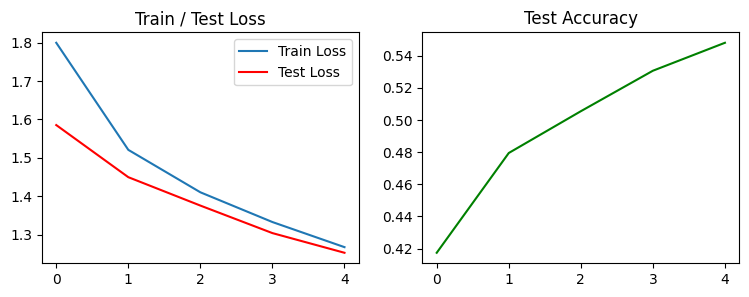

In [ ]:
plot_results(train_losses, test_losses, accuracies)

Q2) After analyzing the plot, we can conclude that the model is learning gradually. This is demonstrated by the consistent increase in test accuracy and decease in both training and test loss over all epochs. By the end of training, the model reached a test accuracy of approximately 55%, and the train and test losses were around 1.2. The results imply that the overall model was successful for a SimpleCNN that was trained for only 5 epochs.

# Q3. Run the following experiments and report the results.
- Train and evaluate the `ResNet50_Weights` model on the CIFAR-10 dataset (for 5 epochs minimum).
- Plot the train and test loss, as well as the test accuracy.
- Analyze and report the results. Provide reasoning for your analysis. Make comparisons to the previous experiments when appropriate.

In [ ]:
T = ResNet50_Weights.DEFAULT.transforms()
train_loader, test_loader = load_data(T, BATCH_SIZE)

resnet_transfer = ResNet50Transfer(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(resnet_transfer.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = run_experiment(resnet_transfer, train_loader, test_loader, optimizer, criterion, device, EPOCHS)

Finished training.


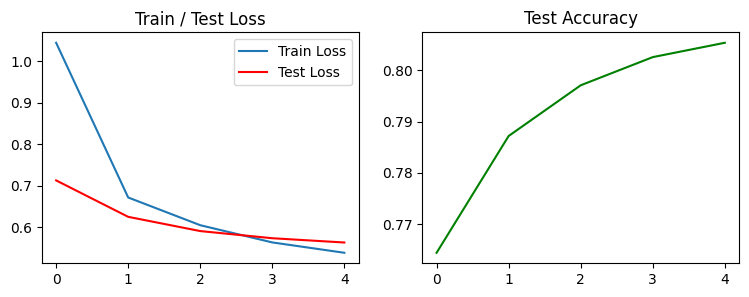

In [ ]:
plot_results(train_losses, test_losses, accuracies)

Q3) After analyzing the plot, this model performed significantly better than the SimpleCNN over the 5 epochs. The model was faster as it consistently increased test accuracy and decreased train and test losses. By the end of training, the model reached a test accuracy of approximately 81%, and both the train and test losses were around 0.5. The results suggest that the overall model was successful and notably better than previous model since it acheived a higher test accuracy and lower train and test losses over 5 epochs.